### Uses CROCO surface variables for Spectral Analysis
##### Computes SST'xHFX' and regression coefficient

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [7]:
def SMfield(var,g_sigma=None,time_str='dayofyear'):
    from scipy.ndimage import gaussian_filter as gauss
    var_smoothed=var.copy()
    
    for ix in range(var[time_str].shape[0]):
        var_smoothed[ix]=gauss(var[ix].data,g_sigma)
    
    var_prime=var-var_smoothed
    return var_smoothed,var_prime

In [2]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [44]:
dxx=0.5
dyy=dxx

In [41]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [5]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Spectral Analysis

#### Test - SST and Heatflux

In [6]:
chunks_new={'dayofyear':40}
tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);

In [7]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,300:-300,90:700].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,300:-300,90:700].compute();


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,300:-300,90:700].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,300:-300,90:700].compute();


CPU times: user 1min 13s, sys: 14.9 s, total: 1min 28s
Wall time: 9.36 s


In [32]:
with ProgressBar():
    TTf=xrft.isotropic_power_spectrum(tf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True)
    
    TTt=xrft.isotropic_power_spectrum(tt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
                                      dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

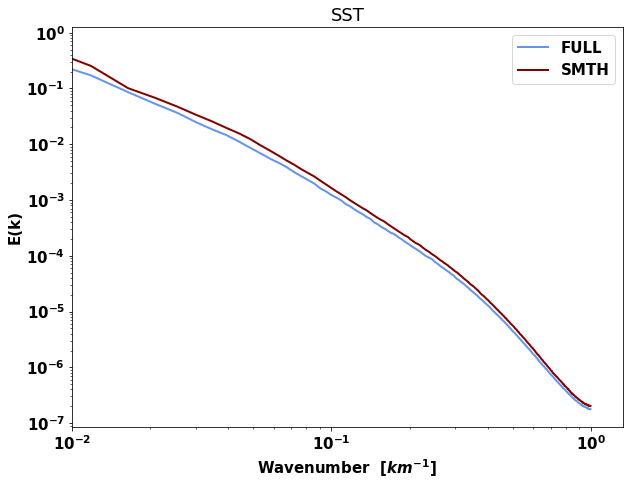

In [35]:
plt.figure(figsize=(9,7))


plt.plot(TTf.freq_r/dxx,TTf.mean(axis=0),label='FULL',linewidth=2,color='cornflowerblue')

plt.plot(TTt.freq_r/dxx,TTt.mean(axis=0),label='SMTH',linewidth=2,color='maroon')


plt.legend()

plt.yscale('log')
plt.xscale('log')


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])


plt.title('SST')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(1/100,0)
# plt.ylim(1e-8,1e-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SST.png')

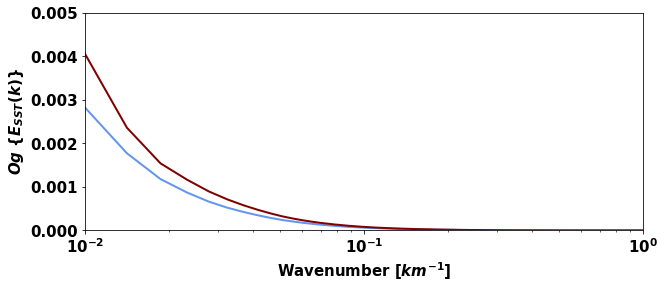

In [44]:
'Ogive graph - Backwards'

Tof=TTf.mean(axis=0)
Tot=TTt.mean(axis=0)

Kk=np.array(TTf.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


TOf=integ.cumtrapz(y=Tof[::-1],x=Kk[::-1]);
TOt=integ.cumtrapz(y=Tot[::-1],x=Kk[::-1]);

TOf=-TOf[::-1]
TOt=-TOt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((Kx),TOf,label='FULL',linewidth=2,color='cornflowerblue')
ax.plot((Kx),TOt,label='SMTH',linewidth=2,color='maroon')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{SST}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(1e-2,1)
ax.set_ylim(0,5e-3)
ax.set_xscale('log')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_Ogive_SST.png')

# Calculating VBP

In [8]:
# sf=varf.salt.groupby("time_counter.dayofyear").mean()
# sf=sf.chunk(chunks=chunks_new);
# sf=sf[:,300:-300,90:700].compute();

# st=vart.salt.groupby("time_counter.dayofyear").mean()
# st=st.chunk(chunks=chunks_new);
# st=st[:,300:-300,90:700].compute();


# wf=varf.w.groupby("time_counter.dayofyear").mean()
# wf=wf.chunk(chunks=chunks_new);
# wf=wf[:,300:-300,90:700].compute();

# wt=vart.w.groupby("time_counter.dayofyear").mean()
# wt=wt.chunk(chunks=chunks_new);
# wt=wt[:,300:-300,90:700].compute();



In [9]:
# import xroms 

# rhof=xroms.potential_density(tf,sf)
# rhot=xroms.potential_density(tt,st)

In [10]:
# bf=xroms.buoyancy(rhof)#[:,1:-1,:]
# bt=xroms.buoyancy(rhot)#[:,1:-1,:]

In [11]:
# %%time
# with ProgressBar():
#     VBPf=xrft.isotropic_cross_spectrum(wf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),bf.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True)
    
#     VBPt=xrft.isotropic_cross_spectrum(wt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),bt.drop(['nav_lat_rho','nav_lon_rho','dayofyear']),
#                                       dim=['y_rho','x_rho'],nfactor=2,truncate='True',detrend='linear', window=True)

In [12]:

# plt.figure(figsize=(9,7))


# plt.plot(VBPf.freq_r/dxx,VBPf.mean(axis=0),label='FULL',linewidth=2,color='turquoise')
# plt.plot(VBPt.freq_r/dxx,VBPt.mean(axis=0),label='SMTH',linewidth=2,color='tomato')

# # plt.plot([1/50,1/50],[1000,0],'k--')





# plt.legend()

# plt.yscale('symlog',linthreshy=1e-11)
# plt.xscale('log')



# # plt.title('EKE')
# plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
# plt.ylabel(r'E(k)',fontweight='bold')

# plt.xlim(1/100,1)
# plt.ylim(-1e-11,1e-8)
# plt.tight_layout()

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_VBP.png')

In [13]:
# 'Ogive graph - Backwards'


# Kf=np.nanmean(VBPf,axis=0)
# Kt=np.nanmean(VBPt,axis=0)

# Kk=np.array(VBPf.freq_r)
# Kx=(Kk[:-1]+Kk[1:])/2
# dK=np.diff(Kk)[0]


# KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
# KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

# KAf=-KAf[::-1]
# KAt=-KAt[::-1]

# fig,ax = plt.subplots(figsize=(10,4))
# ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='turquoise')
# ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='tomato')
# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

# ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
# ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
# ax.set_xlim(-2,-0.5)
# # ax.set_ylim(-1e-5,5e-4)



# ax.legend()

# ax2=ax.twinx()
# ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
# ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Ogive_Total_VBP.png')

# Calculating EKE

In [20]:
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



In [28]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [38]:
with ProgressBar():
    Uf=xrft.isotropic_power_spectrum(uf,dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vf=xrft.isotropic_power_spectrum(vf,dim=['x_v','y_v'],nfactor=2,truncate='True',detrend='linear', window=True)
    Ut=xrft.isotropic_power_spectrum(ut,dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)
    Vt=xrft.isotropic_power_spectrum(vt,dim=['x_v','y_v'],nfactor=2,truncate='True',detrend='linear', window=True)



In [39]:
Ekef=xr.DataArray(data=0.5*(Uf.data + Vf.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))
Eket=xr.DataArray(data=0.5*(Ut.data + Vt.data),coords=({'dayofyear':Uf.dayofyear,'freq_r':Uf.freq_r.data}))

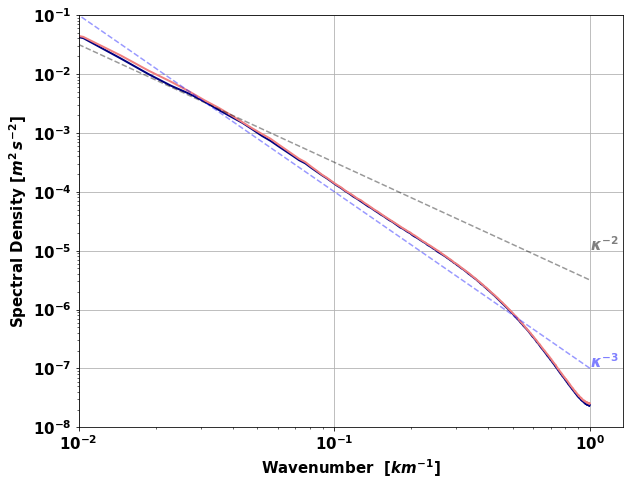

In [55]:

plt.figure(figsize=(9,7))


plt.plot(Uf.freq_r/dxx,Ekef.mean(axis=0),label='FULL',linewidth=2,color='navy')

plt.plot(Eket.freq_r/dxx,Eket.mean(axis=0),label='SMTH',linewidth=2,color='lightcoral')

# plt.plot([1/50,1/50],[1000,0],'k--')


k2 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**5.5)

k3 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**7)

# k53 = np.array([Ekef.freq_r[0],Ekef.freq_r[-1]])/dxx
# E53 = (1/k53)**(5/3)/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-7,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)

# # plt.plot(k53,E53,'g--',alpha=0.4)
# # plt.text(1,1e-3,r'$\kappa^{-5/3}$',weight='normal',color='g',alpha=0.5)


plt.grid()

# plt.legend()

plt.yscale('log')
plt.xscale('log')



plt.ylabel(r'Spectral Density [$m^2\,s^{-2}$]',fontweight='bold',fontsize=15)

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')

plt.xlim(1/100,0)
plt.ylim(1e-8,1e-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_KE.png')

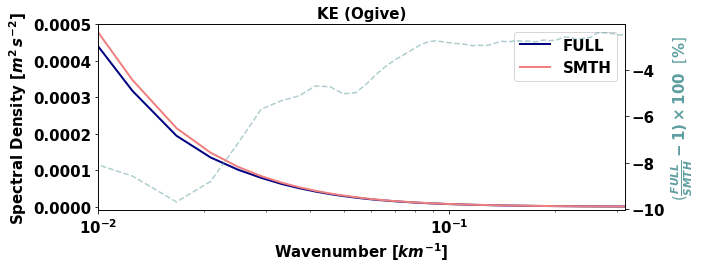

In [65]:
'Ogive graph - Backwards'


Kf=np.nanmean(Ekef,axis=0)
Kt=np.nanmean(Eket,axis=0)

Kk=np.array(Ekef.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((Kx),KAf,label='FULL',linewidth=2,color='navy')
ax.plot((Kx),KAt,label='SMTH',linewidth=2,color='lightcoral')
ax.set_title('KE (Ogive)',fontsize=15,fontweight='bold')


ax.set_xscale('log')




# ax.set_xticks(np.array([-2,-1]))
# ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])


ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'Spectral Density [$m^2\,s^{-2}$]',fontweight='bold',fontsize=15)

ax.set_xlim(1e-2,10**-0.5)
ax.set_ylim(-1e-5,5e-4)



ax.legend()

ax2=ax.twinx()
ax2.plot((Kx),((KAf)/(KAt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}-1)\times 100$  [$\%$]',fontsize=15,color='cadetblue')

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Ogive_avg_KE.png')

### Monthly Averages

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


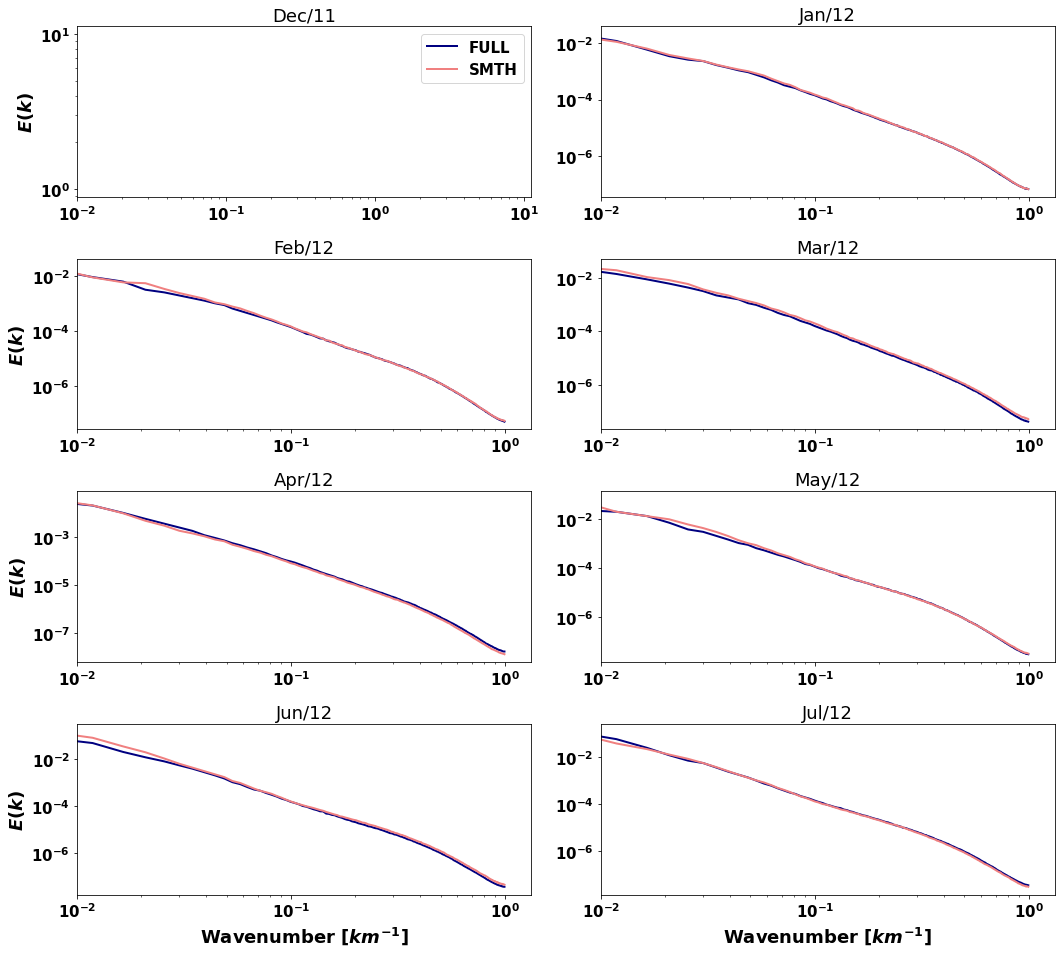

In [117]:
fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot((Ekef.freq_r/dxx),(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='navy')
    axs[ipp].plot((Eket.freq_r/dxx),(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='lightcoral')
    # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
    # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
    # axs[ipp].grid()
    axs[ipp].set_xscale('log')
    axs[ipp].set_yscale('log')



    axs[ipp].set_title(mes_str[ipp])
    # axs[ipp].set_xticks(np.array([-2,-1]))
    # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
    # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

    axs[0].legend()


    axs[ipp].set_xlim(1e-2,0)
    # axs[ipp].set_ylim(-6,-1)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/monthly_KE.png')

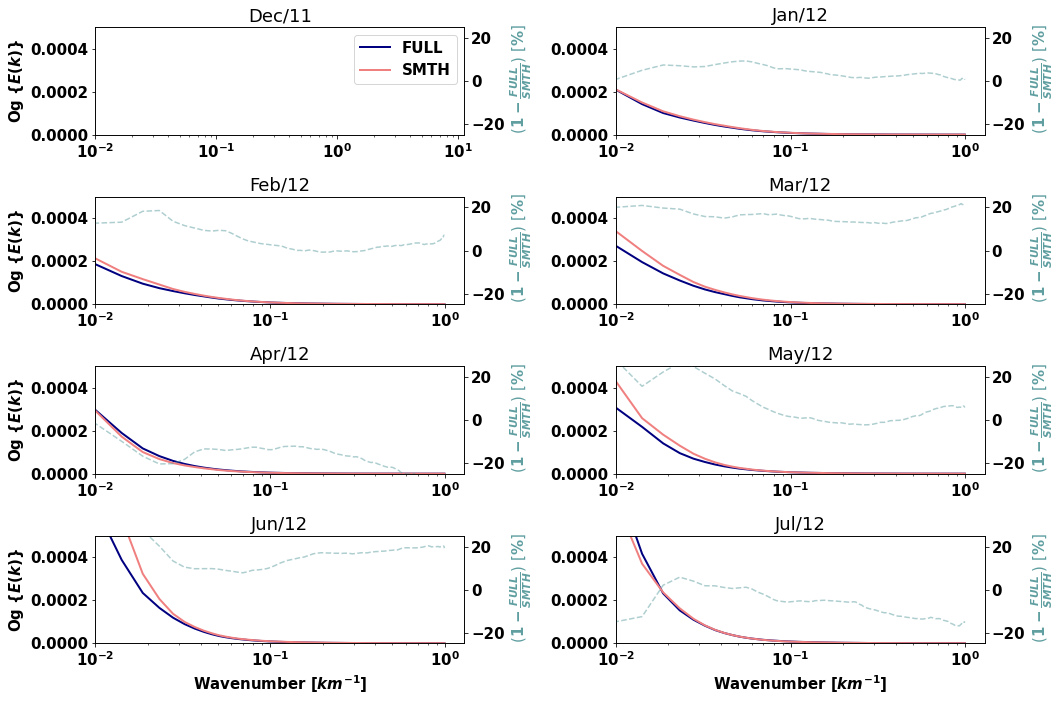

In [118]:
fig, axs = plt.subplots(4,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    emf=np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)
    emt=np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(Ekef.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    KEf=integ.cumtrapz(y=emf[::-1],x=Kk[::-1]);
    KEt=integ.cumtrapz(y=emt[::-1],x=Kk[::-1]);
    KEf=-KEf[::-1]
    KEt=-KEt[::-1]

    

    
    axs[ipp].plot((Kx),KEf,label='FULL',linewidth=2,color='navy')
    axs[ipp].plot((Kx),KEt,label='SMTH',linewidth=2,color='lightcoral')

    axs[ipp].set_title(mes_str[ipp])
    axs[ipp].set_xscale('log')

    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'Og {$E(k)$}',color="k",fontsize=15,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')

    axs[0].legend()
    axs[ipp].set_xlim(1e-2,0)
    axs[ipp].set_ylim(-1e-6,5e-4)


#     axs[ipp].set_xticks(np.array([-2,-1]))
#     axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    

    ax2=axs[ipp].twinx()
    ax2.plot((Kx),(1-(KEf)/(KEt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    # if ipp in [2,5,8]:
    ax2.set_xscale('log')
    ax2.set_ylabel(r' ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    ax2.set_ylim(-25,25)
    plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Ogive_monthly_KE.png')

    

## Windwork

In [66]:
#loading stress

usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
# usf=usf[:,300:-300,90:700].compute();
usf=usf.compute();



ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();
# ust=ust[:,300:-300,90:700].compute();



vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();
# vsf=vsf[:,300:-300,90:700].compute();


vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
# vst=vst[:,300:-300,90:700].compute();
vst=vst.compute();



In [67]:
usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [69]:
    Xf=xrft.isotropic_cross_spectrum(usf,uf,
                                     dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 1d, C), int64, complex128)
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 1d, C), int64, complex128)':
   No match.

During: typing of setitem at /homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py (375)

File "../../miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py", line 375:
    def _inner(ri, val, ret, counter, mean):
        <source elided>
        counter[ri] += 1
        ret[ri] += val
        ^

During: resolving callee type: type(CPUDispatcher(<function Mean._inner at 0x7f197443dae8>))
During: typing of call at /homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py (127)

During: resolving callee type: type(CPUDispatcher(<function Mean._inner at 0x7f197443dae8>))
During: typing of call at /homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py (127)


File "../../miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py", line 127:
        def _loop(group_idx, a, ret, counter, mean, outer, fill_value, ddof):
            <source elided>
                val = valgetter(a, i)
                inner(ri, val, ret, counter, mean)
                ^

During: resolving callee type: type(CPUDispatcher(<function AggregateOp.callable.<locals>._loop at 0x7f197430bea0>))
During: typing of call at /homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py (167)

During: resolving callee type: type(CPUDispatcher(<function AggregateOp.callable.<locals>._loop at 0x7f197430bea0>))
During: typing of call at /homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py (167)


File "../../miniconda3/envs/ROMS/lib/python3.7/site-packages/numpy_groupies/aggregate_numba.py", line 167:
        def _loop_2pass(group_idx, a, ret, counter, mean, outer, fill_value, ddof):
            loop(group_idx, a, ret, counter, mean, outer, fill_value, ddof)
            ^


In [125]:
with ProgressBar():
    Xf=xrft.isotropic_cross_spectrum(usf.drop(['nav_lat_u', 'nav_lon_u']),uf.drop(['nav_lat_u', 'nav_lon_u']),
                                     dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)
    Yf=xrft.isotropic_cross_spectrum(vsf.drop(['nav_lat_v', 'nav_lon_v']),vf.drop(['nav_lat_v', 'nav_lon_v']),
                                     dim=['x_v','y_v'],nfactor=2,truncate='True',detrend='linear', window=True)

    Xt=xrft.isotropic_cross_spectrum(ust.drop(['nav_lat_u', 'nav_lon_u']),ut.drop(['nav_lat_u', 'nav_lon_u']),
                                     dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)
    Yt=xrft.isotropic_cross_spectrum(vst.drop(['nav_lat_v', 'nav_lon_v']),vt.drop(['nav_lat_v', 'nav_lon_v']),
                                     dim=['x_v','y_v'],nfactor=2,truncate='True',detrend='linear', window=True)

In [130]:

WWf=xr.DataArray(data=(1/1024)*(Xf.real.data + Yf.real.data),coords=({'dayofyear':Xf.dayofyear,'freq_r':Xf.freq_r.data}));
WWt=xr.DataArray(data=(1/1024)*(Xt.real.data + Yt.real.data),coords=({'dayofyear':Xf.dayofyear,'freq_r':Xf.freq_r.data}));

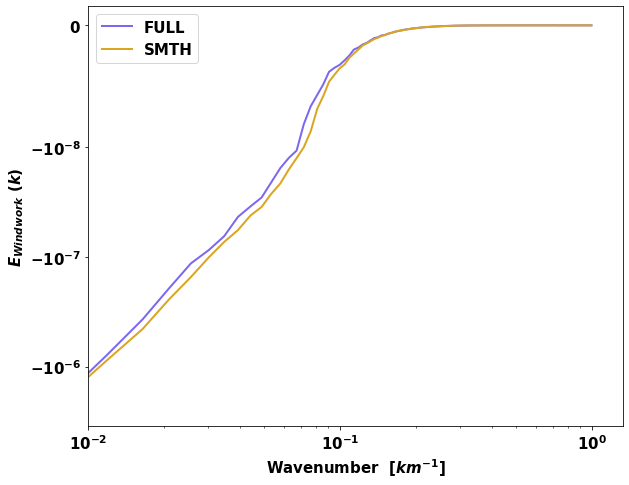

In [132]:

plt.figure(figsize=(9,7))


plt.plot((WWf.freq_r/dxx),(np.nanmean(WWf,axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
plt.plot((WWt.freq_r/dxx),(np.nanmean(WWt,axis=0)),label='SMTH',linewidth=2,color='goldenrod')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{Windwork}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-8)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_Windwork_KE.png')



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


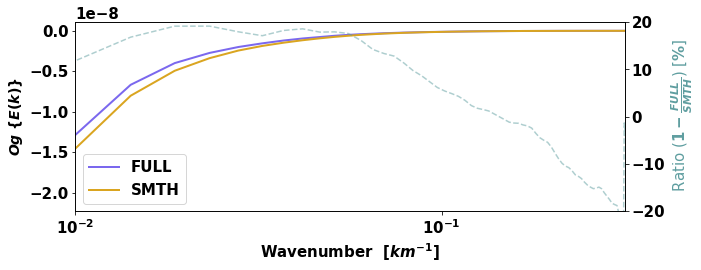

In [133]:
'Ogive'

wwf=np.nanmean(WWf,axis=0)
wwt=np.nanmean(WWt,axis=0)

Kk=np.array(WWf.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


WWpf=integ.cumtrapz(y=wwf[::-1],x=Kk[::-1]);
WWpt=integ.cumtrapz(y=wwt[::-1],x=Kk[::-1]);
WWpf=-WWpf[::-1]
WWpt=-WWpt[::-1]



fig,ax = plt.subplots(figsize=(10,4))
ax.plot(np.log10(Kx),WWpf,label='FULL',linewidth=2,color='mediumslateblue')
ax.plot(np.log10(Kx),WWpt,label='SMTH',linewidth=2,color='goldenrod')
ax.set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E(k)$}',color="k",fontsize=14,fontweight='bold')

ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
# ax.set_ylim(0,6e-11)
ax.set_xlim(-2,-0.5)
ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-((WWpf)/(WWpt)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
ax2.set_ylim(-20,20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Ogive_avg_Windwork.png')




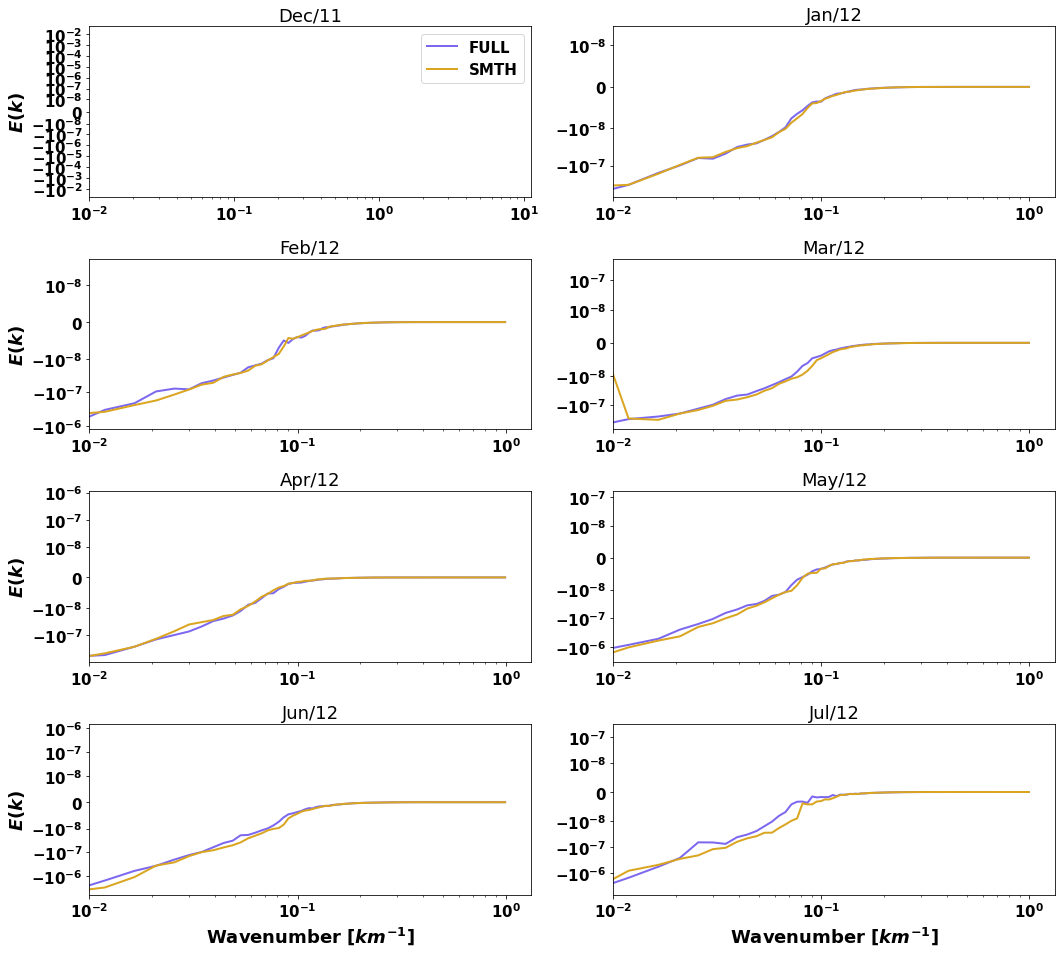

In [136]:
fig, axs = plt.subplots(4,2, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot((WWf.freq_r/dxx),(np.nanmean(WWf[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
    axs[ipp].plot((WWf.freq_r/dxx),(np.nanmean(WWt[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='goldenrod')
    # axs[ipp].plot((k3),(E3),'k--',alpha=0.4)
    # axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
    # axs[ipp].grid()
    axs[ipp].set_xscale('log')
    axs[ipp].set_yscale('symlog',linthreshy=1e-8)



    axs[ipp].set_title(mes_str[ipp])
    # axs[ipp].set_xticks(np.array([-2,-1]))
    # axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    # axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
    # axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
    if ipp in [0,2,4,6]:
        axs[ipp].set_ylabel(r'$E(k)$',color="k",fontsize=18,fontweight='bold')
    if ipp in [6,7]:
        axs[ipp].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')

    axs[0].legend()


    axs[ipp].set_xlim(1e-2,0)
    # axs[ipp].set_ylim(-6,-1)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Ogive_monthly_Windwork.png')



## WindStress x SST

In [9]:
chunks_new={'dayofyear':40}

In [13]:
wstr_f=xr.DataArray(data=(np.sqrt(us_f.data**2 + vs_f.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])
wstr_t=xr.DataArray(data=(np.sqrt(us_t.data**2 + vs_t.data**2)),dims=['dayofyear', 'y_rho', 'x_rho'])

In [14]:

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf.compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt.compute();

tf,tt=romspickle.ts2rho_3d(tf,tt)



In [15]:
t_f=tf[:,300:-300,90:700]
t_t=tt[:,300:-300,90:700]

In [18]:
with ProgressBar():
    Cf=xrft.isotropic_cross_spectrum(wstr_f,t_f.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    Ct=xrft.isotropic_cross_spectrum(wstr_t,t_t.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real

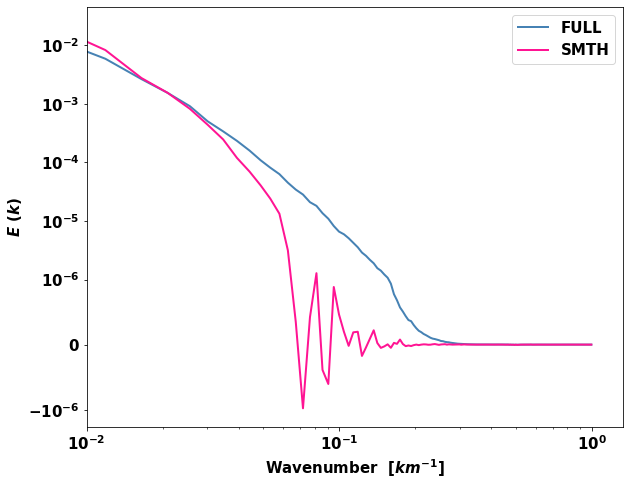

In [22]:

plt.figure(figsize=(9,7))


plt.plot((Cf.freq_r/dxx),(np.nanmean(Cf,axis=0)),label='FULL',linewidth=2,color='SteelBlue')
plt.plot((Ct.freq_r/dxx),(np.nanmean(Ct,axis=0)),label='SMTH',linewidth=2,color='DeepPink')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-6)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_WindStressxSST.png')





## SST x HFX

In [138]:
with ProgressBar():
    Gf=xrft.isotropic_cross_spectrum(tf.drop(['nav_lat_rho', 'nav_lon_rho']),hf.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real
    Gt=xrft.isotropic_cross_spectrum(tt.drop(['nav_lat_rho', 'nav_lon_rho']),ht.drop(['nav_lat_rho', 'nav_lon_rho']),
                                     dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True).real



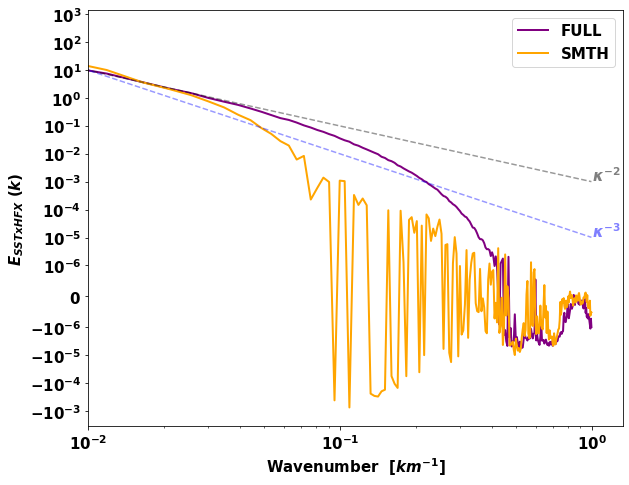

In [142]:

plt.figure(figsize=(9,7))


plt.plot((Gf.freq_r/dxx),(np.nanmean(Gf,axis=0)),label='FULL',linewidth=2,color='purple')
plt.plot((Gt.freq_r/dxx),(np.nanmean(Gt,axis=0)),label='SMTH',linewidth=2,color='orange')
# plt.plot([1/50,1/50],[1000,0],'k--')


plt.legend()



k2 = np.array([Gt.freq_r[0],Gt.freq_r[-1]])/dxx
E2 = (1/k2)**2/(10**3)


k3 = np.array([Gt.freq_r[0],Gt.freq_r[-1]])/dxx
E3 = (1/k3)**3/(10**5)

plt.plot(k2,E2,'k--',alpha=0.4)
plt.text(1,1e-3,r'$\kappa^{-2}$',weight='normal',alpha=0.5)

plt.plot(k3,E3,'b--',alpha=0.4)
plt.text(1,1e-5,r'$\kappa^{-3}$',weight='normal',color='b',alpha=0.5)


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{SSTxHFX}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-6)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/Total_avg_SSTxshflx.png')




## Timeseries analysis - Submesoscale fluctuations

In [7]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf.compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt.compute();


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf.compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht.compute();

CPU times: user 1min 3s, sys: 22.7 s, total: 1min 26s
Wall time: 9.73 s


In [10]:
tf.nav_lon_rho[120:-120,120:800]

<xarray.DataArray 'nav_lon_rho' (y_rho: 1280, x_rho: 680)>
array([[-124.42943 , -124.42474 , -124.420044, ..., -121.188995,
        -121.18411 , -121.17923 ],
       [-124.43207 , -124.42737 , -124.42267 , ..., -121.1915  ,
        -121.186615, -121.18173 ],
       [-124.43469 , -124.42999 , -124.42531 , ..., -121.194   ,
        -121.18912 , -121.18425 ],
       ...,
       [-128.0254  , -128.02051 , -128.0156  , ..., -124.62872 ,
        -124.6236  , -124.61847 ],
       [-128.02841 , -128.02351 , -128.0186  , ..., -124.63162 ,
        -124.626495, -124.62137 ],
       [-128.03143 , -128.02652 , -128.0216  , ..., -124.63451 ,
        -124.62938 , -124.62425 ]], dtype=float32)
Coordinates:
    nav_lat_rho  (y_rho, x_rho) float32 33.28 33.28 33.28 ... 39.81 39.81 39.81
    nav_lon_rho  (y_rho, x_rho) float32 -124.4 -124.4 -124.4 ... -124.6 -124.6
Dimensions without coordinates: y_rho, x_rho
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east

In [11]:
varf.u.time_counter[::4]

<xarray.DataArray 'time_counter' (time_counter: 213)>
array(['2012-01-01T06:00:00.000000000', '2012-01-02T06:00:00.000000000',
       '2012-01-03T06:00:00.000000000', ..., '2012-07-29T06:00:00.000000000',
       '2012-07-30T06:00:00.000000000', '2012-07-31T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time_instant  (time_counter) datetime64[ns] dask.array<chunksize=(31,), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2012-01-01T06:00:00 ... 2012-...
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1979-01-01 00:00:00
    bounds:         time_counter_bounds

In [12]:
# plt.figure(figsize=(10,8))
# plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,tf[0])
# plt.contourf(tf.nav_lon_rho[120:-120,120:800],tf.nav_lat_rho[120:-120,120:800],tf[0,120:-120,120:800])
# plt.plot(tf.nav_lon_rho[120:-120,120:800][720,320],tf.nav_lat_rho[120:-120,120:800][720,320],'*b')
# plt.plot(tf.nav_lon_rho[840,440],tf.nav_lat_rho[840,440],'*m')





In [12]:

uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
ut=ut.compute();



vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
vt=vt.compute();



uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
ut,vt,_=romspickle.uvw2rho_3d(ut,vt,vt)


In [18]:
uf

<xarray.DataArray 'u' (dayofyear: 214, y_u: 1518, x_u: 998)>
array([[[-0.02077319, -0.01331019, -0.01392571, ...,         nan,
                 nan,         nan],
        [-0.01615479, -0.01177619, -0.01257676, ...,         nan,
                 nan,         nan],
        [-0.01437623, -0.01100109, -0.01186089, ...,         nan,
                 nan,         nan],
        ...,
        [-0.05302101, -0.05459417, -0.05426398, ...,         nan,
                 nan,         nan],
        [-0.05441716, -0.05528401, -0.05451497, ...,         nan,
                 nan,         nan],
        [-0.05487595, -0.05553569, -0.05465969, ...,         nan,
                 nan,         nan]],

       [[-0.00492916, -0.00823988, -0.01176591, ...,         nan,
                 nan,         nan],
        [-0.00834154, -0.00983092, -0.01215636, ...,         nan,
                 nan,         nan],
        [-0.01077386, -0.01128099, -0.01270979, ...,         nan,
                 nan,         nan],
...
        [-0.05880185, -0.05795188, -0.05630299, ...,         nan,
                 nan,         nan],
        [-0.05871601, -0.0578903 , -0.05640738, ...,         nan,
                 nan,         nan],
        [-0.05852964, -0.05776808, -0.05650522, ...,         nan,
                 nan,         nan]],

       [[-0.15827516, -0.16107042, -0.15878284, ...,         nan,
                 nan,         nan],
        [-0.16052926, -0.16237147, -0.15933155, ...,         nan,
                 nan,         nan],
        [-0.16316709, -0.16430652, -0.16134903, ...,         nan,
                 nan,         nan],
        ...,
        [-0.09705178, -0.10779037, -0.10578923, ...,         nan,
                 nan,         nan],
        [-0.09401289, -0.10486998, -0.10377841, ...,         nan,
                 nan,         nan],
        [-0.09186283, -0.10133429, -0.10071857, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214
Dimensions without coordinates: y_u, x_u

In [107]:
# uf=uf[:,120:-120,120:800]
# vf=vf[:,120:-120,120:800]
# ut=ut[:,120:-120,120:800]
# vt=vt[:,120:-120,120:800]

In [22]:
gnum=4.5


sst_fg,sst_fp=SMfield(tf,g_sigma=gnum,time_str='dayofyear')
sst_tg,sst_tp=SMfield(tt,g_sigma=gnum,time_str='dayofyear')

u_fg,u_fp=SMfield(uf,g_sigma=gnum)
u_tg,u_tp=SMfield(ut,g_sigma=gnum)

v_fg,v_fp=SMfield(vf,g_sigma=gnum)
v_tg,v_tp=SMfield(vt,g_sigma=gnum)


ske_fp=0.5*(u_fp.data**2 + v_fp.data**2) 
ske_tp=0.5*(u_tp.data**2 + v_tp.data**2)

h_fg,h_fp=SMfield(hf,g_sigma=gnum)
h_tg,h_tp=SMfield(ht,g_sigma=gnum)




#### Testing with spectra

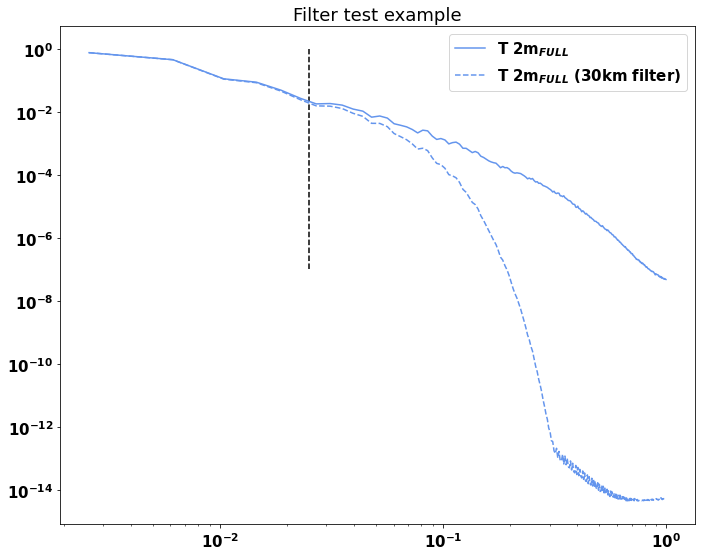

In [31]:

aa=xrft.isotropic_power_spectrum(tf[0,120:-120,120:800].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
bb=xrft.isotropic_power_spectrum(sst_fg[0,120:-120,120:800].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)

cc=xrft.isotropic_power_spectrum(tt[0,120:-120,120:800].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
dd=xrft.isotropic_power_spectrum(sst_tg[0,120:-120,120:800].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)



plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-7,1],'k--')
# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')

plt.plot(aa.freq_r/dxx,aa,color='cornflowerblue',label=r'T 2m$_{FULL}$')
plt.plot(bb.freq_r/dxx,bb,color='cornflowerblue',linestyle='--',label=r'T 2m$_{FULL}$ (30km filter)')

# plt.plot(cc.freq_r/dx,cc,color='purple',label=r'T 2m$_{SMTH}$')
# plt.plot(dd.freq_r/dx,dd,color='purple',linestyle='--',label=r'T 2m$_{SMTH}$ (30km filter)')
plt.legend()


plt.yscale('log')
plt.xscale('log')


plt.tight_layout()

#### Horizontal Mean

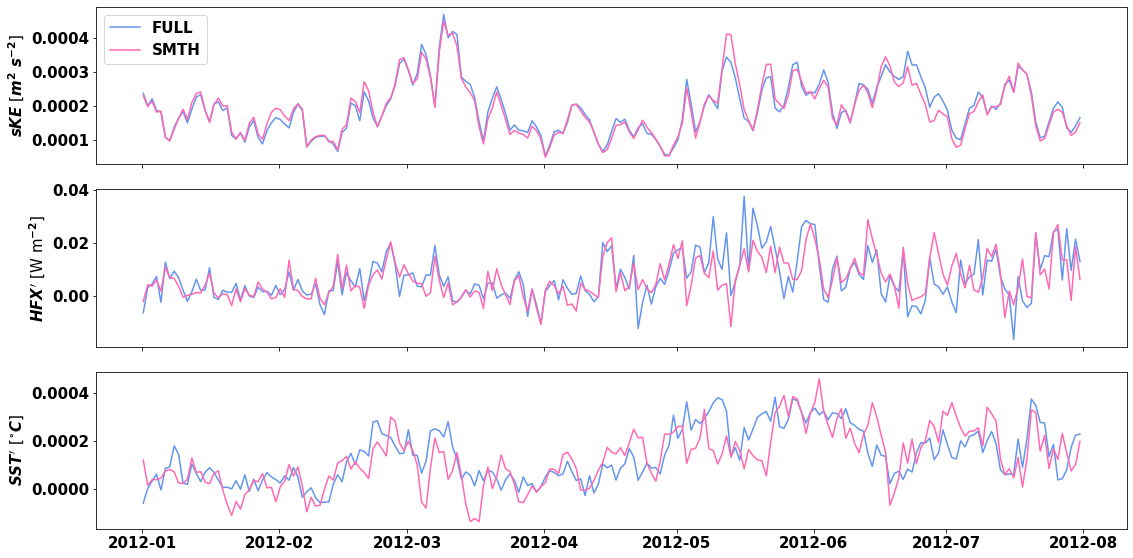

In [36]:
plt.figure(figsize=(16,8))
plt.subplot(3,1,1)

plt.plot(varf.u.time_counter[::4],ske_fp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='cornflowerblue',label='FULL')
plt.plot(varf.u.time_counter[::4],ske_tp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='hotpink',label='SMTH')

plt.legend()
plt.xlabel('')
plt.ylabel('$sKE$ [$m^2$ $s^{-2}$]')
plt.tick_params(axis='x',labelbottom=False)


plt.subplot(3,1,2)

plt.plot(varf.u.time_counter[::4],h_fp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='cornflowerblue')
plt.plot(varf.u.time_counter[::4],h_tp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='hotpink')

plt.xlabel('')
plt.ylabel('$HFX^{\prime}$ [W m$^{-2}$]')
plt.tick_params(axis='x',labelbottom=False)


plt.subplot(3,1,3)

plt.plot(varf.u.time_counter[::4],sst_fp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='cornflowerblue')
plt.plot(varf.u.time_counter[::4],sst_tp[:-1,120:-120,120:800].mean(axis=1).mean(axis=1),color='hotpink')

plt.xlabel('')
plt.ylabel('$SST^{\prime}$ [$^{\circ}C$]')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/OCEAN_timeseries_horizontalmean.png')

##### Central grid-point

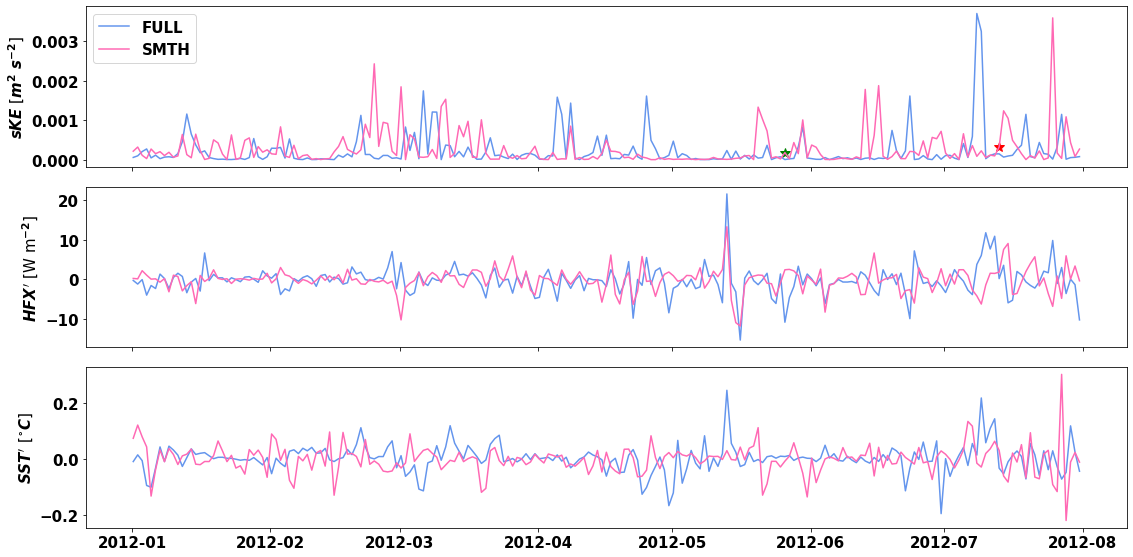

In [39]:
plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
id=194


plt.plot(varf.u.time_counter[::4][146],ske_tp[146,840,440],'g*',markersize=10)
plt.plot(varf.u.time_counter[::4][194],ske_tp[194,840,440],'r*',markersize=10)


plt.plot(varf.u.time_counter[::4],ske_fp[:-1,840,440],color='cornflowerblue',label='FULL')
plt.plot(varf.u.time_counter[::4],ske_tp[:-1,840,440],color='hotpink',label='SMTH')

plt.legend()
plt.xlabel('')
plt.ylabel('$sKE$ [$m^2$ $s^{-2}$]')

plt.tick_params(axis='x',labelbottom=False)


plt.subplot(3,1,2)

plt.plot(varf.u.time_counter[::4],h_fp[:-1,840,440],color='cornflowerblue')
plt.plot(varf.u.time_counter[::4],h_tp[:-1,840,440],color='hotpink')

plt.xlabel('')
plt.ylabel('$HFX^{\prime}$ [W m$^{-2}$]')
plt.tick_params(axis='x',labelbottom=False)
plt.title('')

plt.subplot(3,1,3)

plt.plot(varf.u.time_counter[::4],sst_fp[:-1,840,440],color='cornflowerblue')
plt.plot(varf.u.time_counter[::4],sst_tp[:-1,840,440],color='hotpink')

plt.xlabel('')
plt.ylabel('$SST^{\prime}$ [$^{\circ}C$]')
plt.title('')


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/OCEAN_timeseries_central_gridpoint.png')

### Investigation on total fields

In [43]:
lonv,latv=varf.nav_lon_rho[120:-120,120:800][1:-1,:],varf.nav_lat_rho[120:-120,120:800][1:-1,:]

In [44]:

magf=uf.copy()
magf.values=np.sqrt((uf.data)**2 + (vf.data)**2)

magt=ut.copy()
magt.values=np.sqrt((ut.data)**2 + (vt.data)**2)




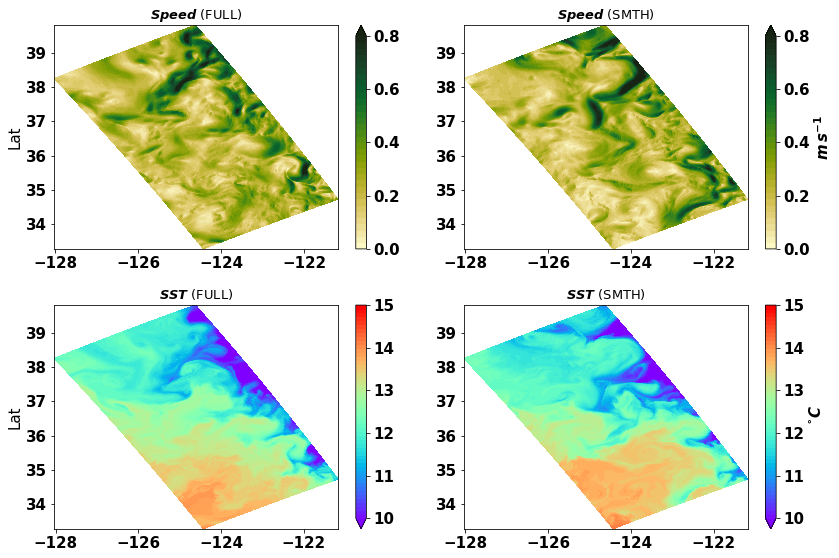

In [46]:
'ke'
import cmocean as cm
id=146
lvls=np.linspace(0,0.8,35)
lv=np.arange(0,1,0.2)
plt.figure(figsize=(12,8))


plt.subplot(2,2,1)

plt.contourf(lonv,latv,magf[id,120:-120,120:800],cmap=cm.cm.speed,levels=lvls,extend='max')
plt.title(r'$Speed$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')
cbar=plt.colorbar()
cbar.set_ticks(lv)

plt.subplot(2,2,2)

plt.contourf(lonv,latv,magt[id,120:-120,120:800],cmap=cm.cm.speed,levels=lvls,extend='max')


plt.title(r'$Speed$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')
cbar=plt.colorbar()
cbar.set_ticks(lv)
cbar.set_label(r'$m\,s^{-1}$')

lvls2=np.arange(10,17,1)


plt.subplot(2,2,3)
tf[id,120:-120,120:800].plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(10,15,55),
                             cbar_kwargs={'ticks': lvls2,'label':' '})
plt.title(r'$SST$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,2,4)

tt[id,120:-120,120:800].plot(x='nav_lon_rho',y='nav_lat_rho',
                             cmap='rainbow',levels=np.linspace(10,15,55),
                             cbar_kwargs={'ticks': lvls2,'label':r' $^{\circ}C$'})
plt.title(r'$SST$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/test_fullvariables_ocean_velsst_{0}.png'.format(pd.DatetimeIndex((varf.time_counter[::4]))[id]))

## Evaluating SST and HFX correlation

In [14]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,1:-1,1:-1]
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,1:-1,1:-1]
tt=tt[:,120:-120,120:800].compute();



CPU times: user 32.2 s, sys: 10.1 s, total: 42.3 s
Wall time: 4.71 s


In [15]:
%%time
chunks_new={'dayofyear':40}

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,1:-1,1:-1]
hf=hf[:,120:-120,120:800].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,1:-1,1:-1]
ht=ht[:,120:-120,120:800].compute();

CPU times: user 34.2 s, sys: 10.7 s, total: 44.9 s
Wall time: 4.48 s


In [16]:
plt.figure(figsize=(9,7))


plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gf/TTf,axis=0)),label='FULL',linewidth=2,color='violet')
plt.plot((cxspec.freq_r/dxx),(np.nanmean(Gt/TTt,axis=0)),label='SMTH',linewidth=2,color='darkorange')
# plt.plot([1/50,1/50],[1000,0],'k--')

plt.plot([1/2,1/2],[-1e3,1e3],'k--')
plt.legend()


# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])



plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{SSTxHFX}\,\,(k)$')

plt.yscale('symlog',linthreshy=1e-1)
plt.xscale('log')

# plt.ylim(-10**(-5),0)
plt.xlim(1e-2,0)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/CROCO/coefficient_GdivT.png')



NameError: name 'cxspec' is not defined

<Figure size 648x504 with 0 Axes>

## Filtering SST and HFLX to find the $\alpha$ coefficient

##### Loading in data

In [17]:
sns.set_style("darkgrid")

In [18]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,1:-1,1:-1]
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,1:-1,1:-1]
tt=tt[:,120:-120,120:800].compute();



CPU times: user 33.1 s, sys: 10.6 s, total: 43.8 s
Wall time: 4.48 s


In [19]:
%%time
chunks_new={'dayofyear':40}

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,1:-1,1:-1]
hf=hf[:,120:-120,120:800].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,1:-1,1:-1]
ht=ht[:,120:-120,120:800].compute();

CPU times: user 33.1 s, sys: 10.5 s, total: 43.6 s
Wall time: 4.35 s


##### Filtering data and testing in the spectra

In [20]:
gnum=4.5

sst_fg,sst_fp=SMfield(tf,g_sigma=gnum,time_str='dayofyear')
sst_tg,sst_tp=SMfield(tt,g_sigma=gnum,time_str='dayofyear')

h_fg,h_fp=SMfield(hf,g_sigma=gnum,time_str='dayofyear')
h_tg,h_tp=SMfield(ht,g_sigma=gnum,time_str='dayofyear')



In [24]:
#band pass
gnum2=0.5
tf_band,_=SMfield(sst_fp,g_sigma=gnum2,time_str='dayofyear')
tt_band,_=SMfield(sst_tp,g_sigma=gnum2,time_str='dayofyear')

hf_band,_=SMfield(h_fp,g_sigma=gnum2,time_str='dayofyear')
ht_band,_=SMfield(h_tp,g_sigma=gnum2,time_str='dayofyear')





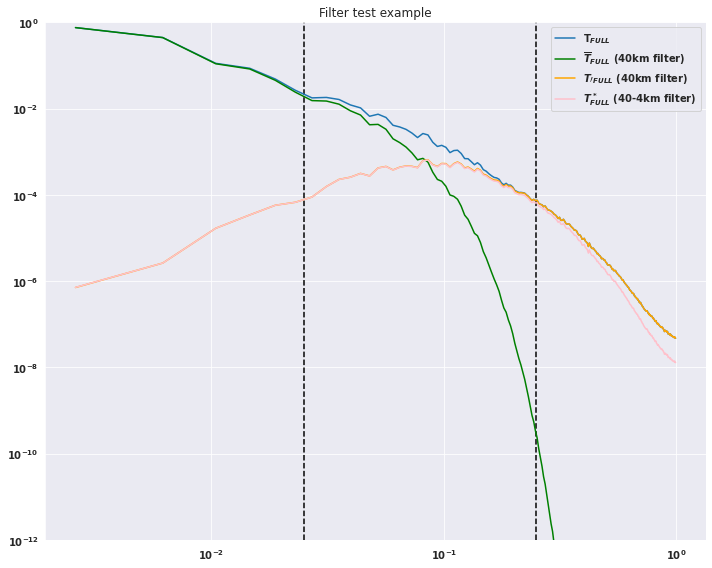

In [25]:

xlim=1
asp=xrft.isotropic_power_spectrum(tf[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(sst_fg[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
csp=xrft.isotropic_power_spectrum(sst_fp[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
dsp=xrft.isotropic_power_spectrum(tf_band[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)




plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
plt.plot([1/4,1/4],[1e-12,1],'k--')


# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')

plt.plot(asp.freq_r/dxx,asp,label=r'T$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp,color='green',label=r'$\overline{T}_{FULL}$ (40km filter)')
plt.plot(csp.freq_r/dxx,csp,color='orange',label=r'$T\prime_{FULL}$ (40km filter)')
plt.plot(dsp.freq_r/dxx,dsp,color='pink',label=r'$T^*_{FULL}$ (40-4km filter)')



plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-12,1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/filter_test_SSTxHFX.png')

In [26]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())

##### Correlation time series

In [27]:
Rsq=np.zeros([h_fp.shape[0]])*np.nan;
Rsqm=np.zeros([h_fp.shape[0]])*np.nan;


for icc in range(Rsq.shape[0]):
    # Rsqx[icc]=np.corrcoef(np.ravel(h_fp[icc]),np.ravel(sst_fp[icc]))[0][1]
    Rsqm[icc]=np.corrcoef(np.ravel(sst_fg[icc]),np.ravel(h_fg[icc]))[0][1]
    Rsq[icc]=np.corrcoef(np.ravel(tf_band[icc]),np.ravel(hf_band[icc]))[0][1]

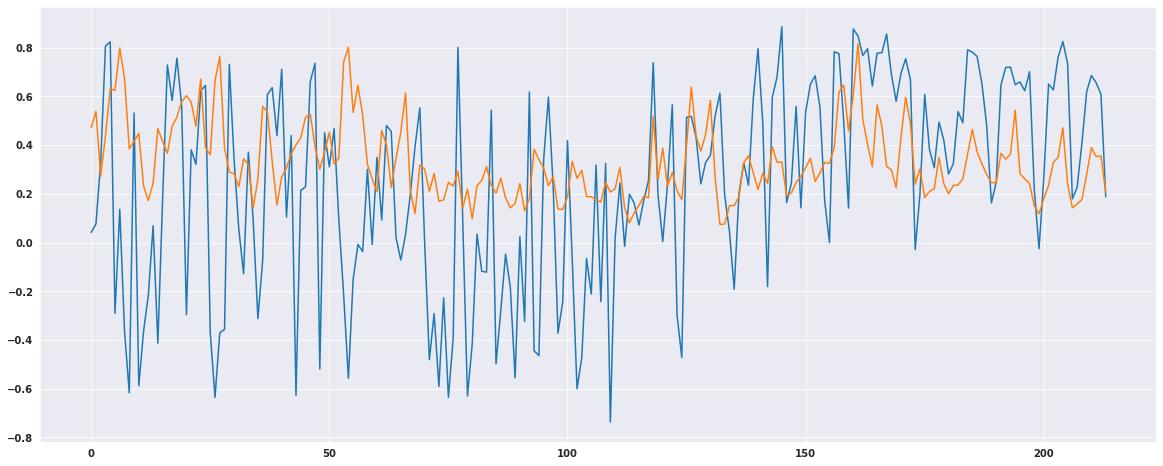

In [28]:
plt.figure(figsize=(20,8))


plt.plot(Rsqm)
plt.plot(Rsq)

In [29]:
np.nanmean(np.abs(Rsqm))

0.4131489694322074

In [30]:
np.nanmean(Rsq)

0.33237621762263003

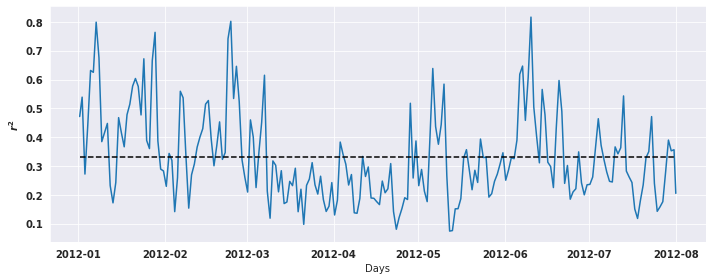

In [31]:
plt.figure(figsize=(10,4))

plt.plot(timer,Rsq)
plt.plot(timer,np.nanmean(Rsq)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/coeff_daily_fluctuations_SSTxHFX.png')



In [32]:
# reg_f=pd.DataFrame({'HFX':np.ravel(h_fp)[::100],'SST':np.ravel(sst_fp)[::100]})
# reg_t=pd.DataFrame({'HFX':np.ravel(h_tp)[::100],'SST':np.ravel(sst_tp)[::100]})

reg_f=pd.DataFrame({'HFX':np.ravel(hf_band)[::100],'SST':np.ravel(tf_band)[::100]})


reg_fbar=pd.DataFrame({'HFX':np.ravel(h_fg)[::100],'SST':np.ravel(sst_fg)[::100]})



In [71]:
dec=1
de=10
# regF=pd.DataFrame({'HFX':np.ravel(h_fp[de])[::dec],'SST':np.ravel(sst_fp[de])[::dec]})
regF=pd.DataFrame({'HFX':np.ravel(hf_band[de])[::dec],'SST':np.ravel(tf_band[de])[::dec]})

In [72]:
# plt.figure(figsize=(10,8))
# sns.regplot(x='SST',y='HFX',data=reg_f,x_bins=80,ci=95,truncate=True)
# plt.xlabel(r'HFX$^{\prime}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
# plt.ylabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=15,fontweight='bold')
# plt.title('FULL ($r^2$={0:.2f})'.format(reg_f.corr()['HFX'][1]),fontsize=15,fontweight='bold')

# plt.xlim(-0.5,0.5)
# plt.ylim(-0.0025,0.0025)
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/regbinned_FULL_SSTxHFX.png')



##### Timeseries of coefficient (slope)

In [73]:
apoly=np.zeros(h_fp.shape[0])*np.nan;
bpoly=np.zeros(h_fp.shape[0])*np.nan;
for ide in range(h_fp.shape[0]):
    dec=1
    regg=pd.DataFrame({'HFX':np.ravel(h_fp[ide])[::dec],'SST':np.ravel(sst_fp[ide])[::dec]})
    apoly[ide],bpoly[ide]=np.polyfit(regg.SST,regg.HFX,deg=1)


Text(0, 0.5, '$\\alpha$ $[W m^{-2}$ $^{\\circ}C$ $^{-1}]$')

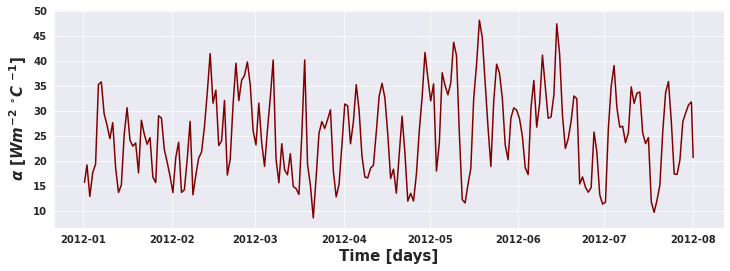

In [74]:
plt.figure(figsize=(12,4))
plt.plot(timer,apoly,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[W m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=15,fontweight='bold')
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_time_series.png')



In [77]:
aa,bb=np.polyfit(reg_f.SST,reg_f.HFX,deg=1)

In [78]:
aa

25.958130570424238

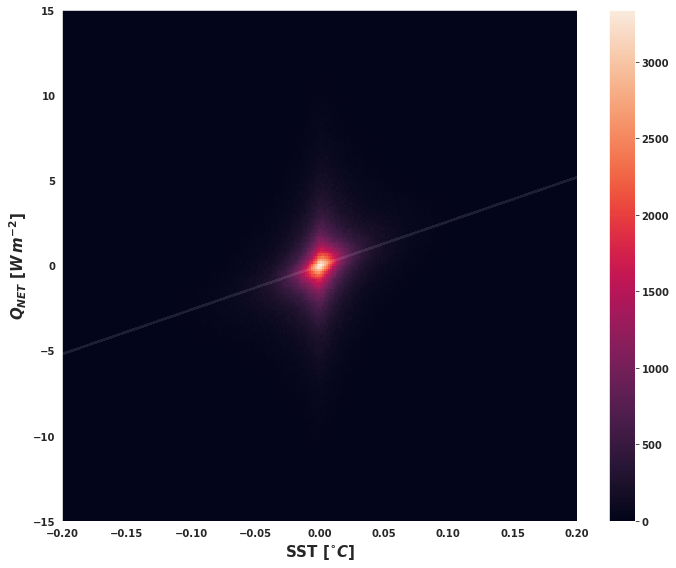

In [108]:
plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.HFX,bins=1000)
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'w--',alpha=0.1)
# plt.grid(color='k')
plt.xlim(-0.2,0.2)
plt.ylim(-15,15)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')


plt.colorbar()
plt.tight_layout()

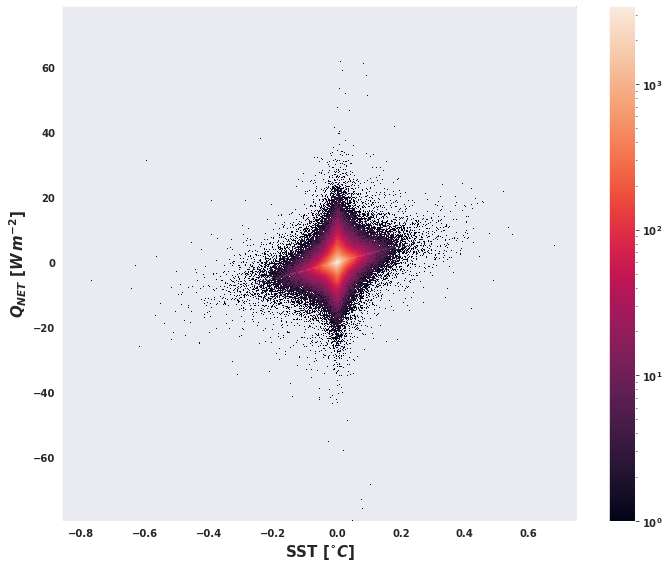

In [81]:
import matplotlib as mpl
dec=1


plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.HFX,bins=1000,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_f.SST,reg_f.HFX,bins=1000)

plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'w--',alpha=0.1)
# plt.grid(color='k')
# plt.xlim(-0.2,0.2)
# plt.ylim(-15,15)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')

plt.colorbar()
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2dhhist_SST-HFX-total.png')



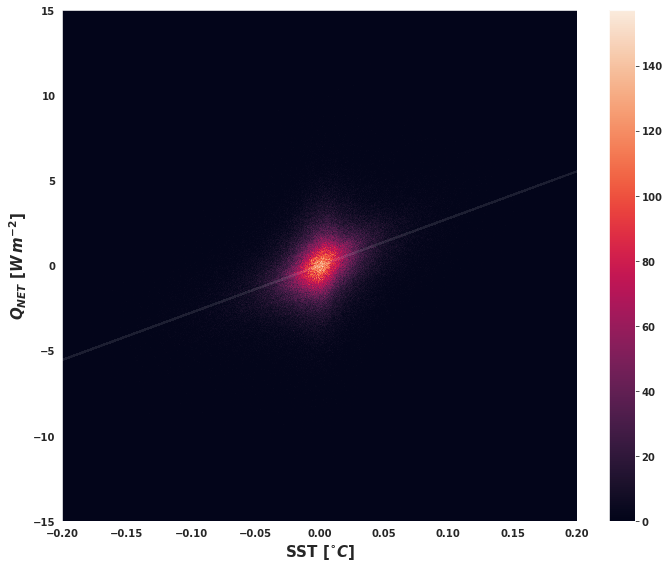

In [41]:
dec=1
plt.figure(figsize=(10,8))
plt.hist2d(regF.SST,regF.HFX,bins=1000)
plt.plot(regF.SST[::dec],(apoly[10]*regF.SST)[::dec],'w--',alpha=0.1)
plt.grid(color='k')
plt.xlim(-0.2,0.2)
plt.ylim(-15,15)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')


plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2dhhist_SST-HFX-day_10.png')



## Filtering SST and wind to find the $\gamma$ coefficient

In [42]:
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

ust=vart.sustr.groupby("time_counter.dayofyear").mean()
ust=ust.chunk(chunks=chunks_new);
ust=ust.compute();


vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();

vst=vart.svstr.groupby("time_counter.dayofyear").mean()
vst=vst.chunk(chunks=chunks_new);
vst=vst.compute();



usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [43]:
gnum=4.5

sst_fg,sst_fp=SMfield(tf,g_sigma=gnum,time_str='dayofyear')
sst_tg,sst_tp=SMfield(tt,g_sigma=gnum,time_str='dayofyear')

us_fg,us_fp=SMfield(usf,g_sigma=gnum,time_str='dayofyear')
us_tg,us_tp=SMfield(ust,g_sigma=gnum,time_str='dayofyear')

vs_fg,vs_fp=SMfield(vsf,g_sigma=gnum,time_str='dayofyear')
vs_tg,vs_tp=SMfield(vst,g_sigma=gnum,time_str='dayofyear')




In [44]:
wsf=usf.copy()
wsf.data=np.sqrt(usf.data**2 + vsf.data**2)

In [45]:
wst=ust.copy()
wst.data=np.sqrt(ust.data**2 + vst.data**2)


In [46]:
ws_fg,ws_fp=SMfield(wsf,g_sigma=gnum,time_str='dayofyear')
ws_tg,ws_tp=SMfield(wst,g_sigma=gnum,time_str='dayofyear')



# ws_fg=np.sqrt(us_fg.data**2+vs_fg.data**2)
# ws_fp=np.sqrt(us_fp.data**2+vs_fp.data**2)

# ws_tg=np.sqrt(us_tg.data**2+vs_tg.data**2)
# ws_tp=np.sqrt(us_tp.data**2+vs_tp.data**2)


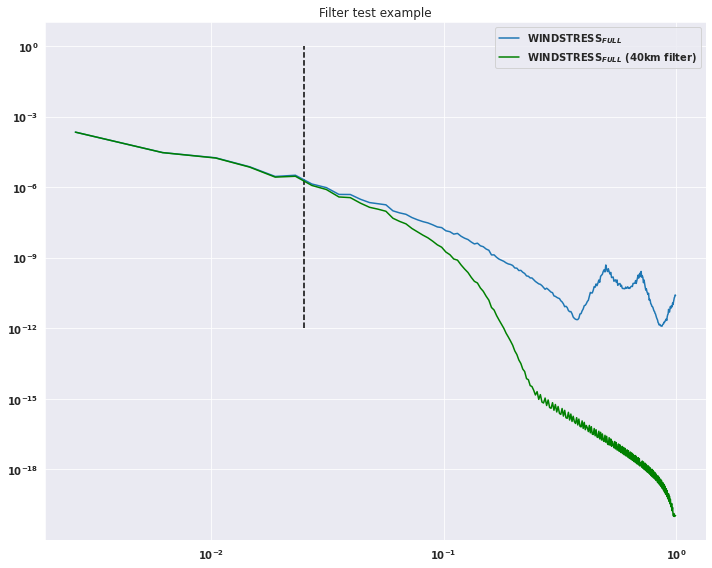

In [47]:

xlim=1
asp=xrft.isotropic_power_spectrum(usf[0,xlim:-xlim,xlim:-xlim],nfactor=2,truncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(us_fg[0,xlim:-xlim,xlim:-xlim],nfactor=2,truncate='True',detrend='linear', window=True)


plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')

plt.plot(asp.freq_r/dxx,asp,label=r'WINDSTRESS$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp,color='green',label=r'WINDSTRESS$_{FULL}$ (40km filter)')
plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.ylim(1e-12,1)
plt.tight_layout()

In [48]:
Rsw=np.zeros([sst_fp.shape[0]])*np.nan;
for icc in range(Rsw.shape[0]):
    Rsw[icc]=np.corrcoef(np.ravel(sst_fp[icc]),np.ravel(ws_fp[icc]))[0][1]

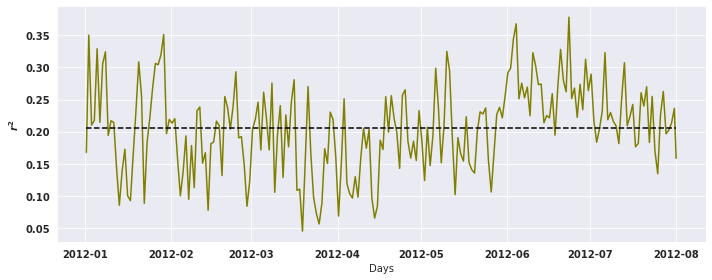

In [208]:
plt.figure(figsize=(10,4))

plt.plot(timer,Rsw,color='olive')
plt.plot(timer,np.nanmean(Rsw)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/coeff_daily_fluctuations_WINDSTRESxSST.png')




In [49]:
regs_f=pd.DataFrame({'SST':np.ravel(sst_fp)[::100],'Tau':np.ravel(ws_fp)[::100]})
regs_t=pd.DataFrame({'SST':np.ravel(sst_tp)[::100],'Tau':np.ravel(ws_tp)[::100]})

In [50]:
dec=1
de=10
regsF=pd.DataFrame({'SST':np.ravel(sst_fp[de])[::dec],'Tau':np.ravel(ws_fp[de])[::dec]})

In [51]:
# plt.figure(figsize=(10,8))
# sns.regplot(x='SST',y='Tau',data=regs_f,x_bins=80,ci=95,truncate=True,order=1)
# plt.ylabel(r'$\,\tau\,^{\prime}$ [$N\,m^{-2}$]',fontsize=15,fontweight='bold')
# plt.xlabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=15,fontweight='bold')
# plt.title('FULL ($r^2$={0:.2f})'.format(regs_f.corr()['SST'][1]),fontsize=15,fontweight='bold')



# plt.xlim(-0.01,0.01)
# plt.ylim(-0.0001,0.0001)
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/regbinned_FULL_WINDSTRESSxSST.png')



In [52]:
# plt.figure(figsize=(10,8))
# sns.regplot(x='SST',y='Tau',data=regs_t,x_bins=80,ci=95,color='red',truncate=True,order=1)
# plt.ylabel(r'$\,\tau\,^{\prime}$ [$N\,m^{-2}$]',fontsize=15,fontweight='bold')

# plt.xlabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=15,fontweight='bold')
# plt.title('SMTH ($r^2$={0:.2f})'.format(regs_t.corr()['SST'][1]),fontsize=15,fontweight='bold')


# plt.xlim(-0.01,0.01)
# plt.ylim(-0.0001,0.0001)

# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/regbinned_SMTH_WINDSTRESSxSST.png')

In [53]:
aas,bbs=np.polyfit(regs_f.SST,regs_f.Tau,deg=1)

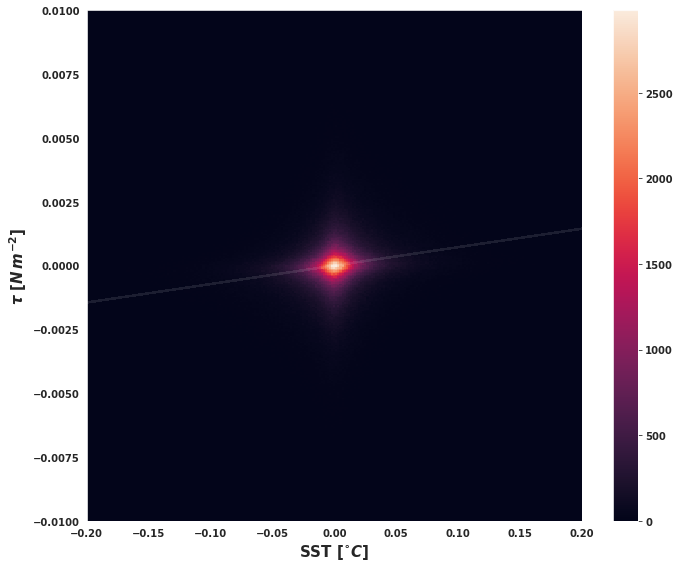

In [55]:
dec=1
plt.figure(figsize=(10,8))
plt.hist2d(regs_f.SST,regs_f.Tau,bins=1000)
plt.plot(regs_f.SST[::dec],(aas*regs_f.SST)[::dec],'w--',alpha=0.1)
plt.grid(color='k')
plt.xlim(-0.2,0.2)
plt.ylim(-0.01,0.01)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\tau$ [$N\,m^{-2}$]',fontsize=15,fontweight='bold')


plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2dhhist_SST-Wind-total.png')
# 
